# Implementing Deep Structured Semantic Model (DSSM) in Theano : <br> Word Embedding Case Study
                
                                       Author: imran.sheikh@loria.fr

## Introduction
In this technical report we try an implementation of the Deep Structured Semantic Model (DSSM), a neural network modeling technique to learn representations of text in a continuous semantic space. DSSM can be seen as generic architecture for developing latent semantic models that project entities of different types e.g., words, sentences, queries, documents into a common low-dimensional semantic space for a variety of machine learning tasks such as ranking and classification. Some of the applications (efficiently) addressed by DSSM include information retrieval and web search  ([Huang et al., 2013](http://research.microsoft.com/pubs/198202/cikm2013_DSSM_fullversion.pdf); [Shen et al., 2014a](http://research.microsoft.com/pubs/214617/www2014_cdssm_p07.pdf), [2014b](http://research.microsoft.com/apps/pubs/default.aspx?id=226585)), ad selection/relevance, contextual entity search ([Gao et al., 2014a](http://research.microsoft.com/apps/pubs/default.aspx?id=226584)), question answering ([Yih et al., 2014](http://research.microsoft.com/apps/pubs/default.aspx?id=214353)), knowledge inference ([Yang et al., 2014](http://arxiv-web3.library.cornell.edu/abs/1412.6575)), image captioning ([Fang et al., 2014](http://arxiv.org/abs/1411.4952)), machine translation ([Gao et al., 2014b](http://research.microsoft.com/apps/pubs/default.aspx?id=211749)) etc. 

The objective of this report is to understand and discuss the technicalities of a typical DSSM learning architecture. To do so we try an implementation of the DSSM model for learning word embeddings: a very common and popular word representation learning task in Natural Language Processing (NLP). DSSM has been shown to work on this task in [Song et al., 2014](http://research.microsoft.com/pubs/226586/MSRTR2014_wordEmbedding.pdf)(which is also a more formal research paper style reference to the implementation discussed in this notebook). But as mentioned earlier this notebook follows an hands-on approach to have a closer look at the DSSM architecture. We believe that this work can serve at least the following two purposes:<br>
[1] help understand how DSSM follow a slightly different neural network modeling approach compared to the conventional $input \rightarrow model \rightarrow output$ pipelines, to address ranking as well classification tasks<br>
[2] make available a theano code for a basic DSSM (which are not straight forward to implement and no implementation being publicly available as far as the knowledge of the author)

## DSSM Architecture
<img src="docs/DSSM.png" width=800>

To begin we first give an overview of the the general DSSM architecture shown in figure above. DSSM was first proposed for information retrieval (IR) task and so it involves terminologies specific to this task. But as mentioned earlier the model itself can be used for a variety of tasks. As indicated by the figure labels on the left, the input to the network (lowest layer) are term vectors (one-hot vectors) which could correspond to different types of entities based on the task e.g., words, sentences, queries, documents. The term vectors are transformed using a word hashing layer which  essentially leads to a (tri-gram) character level representation of the input words. The word hashing layer has two main advantages, (a) it reduces the dimensionality of the input/output layers thus reducing the size and complexity of the model (b) it readily incorporates new and out-of-vocabulary words and errors due to spelling variations. The output of the word hashing layer is given to one or more projection layers which can be deep ([Huang et al., 2013](http://research.microsoft.com/pubs/198202/cikm2013_DSSM_fullversion.pdf)), convolutional ([Shen et al., 2014a](http://research.microsoft.com/pubs/214617/www2014_cdssm_p07.pdf)) or recurrent ([Palangi et al., 2015](http://arxiv.org/pdf/1502.06922.pdf)) neural networks. The output at this stage is the semantic feature vector corresponding to the input. The semantic feature vector is obtained for each of the input term vectors denoted as $Q, D_1, D_2 ... D_n$; namely the query and document input vectors. For example for IR tasks $Q$ corresponds to a query, $D_1$ corresponds to the (positive) document relevant to $Q$ and other documents $D_2, D_3 ... D_n$ may be the (negative) documents not relevant to $Q$. (Note that network parameters for query and document sides are different but shared between positive and negative document samples.) After the semantic feature representations are obtained relevance is measured between the query and document vectors using cosine similarity and posterior probabilities are computed using a softmax layer. It should be noted how the DSSM model follows a different neural network modeling approach compared to the conventional $input \rightarrow model \rightarrow output$ pipeline.

Given $ y_Q $ as the semantic feature vector for a query $Q$ and $ y_D $ as semantic feature vector for document $D$,  the relevance between them is calculated as:
$$
R(Q, D) = Cosine\_Similarity(y_Q, y_D) = \frac{y_Q^T y_D}{\left \| y_Q \right \| \left \| y_D \right \|}
$$

Then the posterior probability of a document given a query can be computed from the semantic relevance score between them through a softmax function as:

$$
P(D_i|Q) = \frac{exp(\gamma R(Q,D_i))}{\sum_i exp(\gamma R(Q,D_i)) }
$$
where $\gamma$ is a smoothing factor. <br>

In training, the model parameters are estimated to maximize the likelihood of the relevant (positive) documents given the queries across the training set. Equivalently, we need to minimize the following loss function

$$
L(\Lambda ) = -log \prod_{(Q,D^+)} P(Q|D^+)
$$

where $\Lambda$ denotes the (weight and bias) parameter set of the neural networks. Since $L(\Lambda )$ is differentiable w.r.t. $\Lambda$, the parameters can be trained using gradient descent method.

## Learning Word Embeddings with DSSM
The DSSM architecture can be directly used for learning word embeddings. To achieve this the classical approach to form small context windows of 10-15 words is adopted. The word at the center of the context window is treated as the positive relevant document and the remaining words in the window are used to form a (bag of word) query. A number of other randomly (but carefully) chosen words are treated as non-relevant (negative) documents for training. This is done for each of the word occurrences in the entire training corpus. And usually multiple epochs of training are carried out, leading to meaningful word embeddings in the context (query) and word (document) side of the DSSM model. In order to understand better let us look at the step-by-step implementation.

### Theano Implementation

(Many snippets in the theano code discussed here are re-used from the [LSTM tutorial at deeplearning.net](http://deeplearning.net/tutorial/lstm.html))

A note on datasets used: <br>
We use two small datasets to demonstrate the training of word embeddings with DSSM. <br>
[1] 'icassp': a very small dataset of titles of papers published at the ICASSP 2014 conference on audio and speech signal processing. The vocabulary is restricted to top 1000 words. <br>
[2] '2014' : a small dataset of French news articles that appeared on the Euronews website between January-June 2014. The vocabulary is restricted to top 5000 words. <br>
The datasets are stored in .pkl files containing indexes from one-hot encoding of words. Since the datasets are too small the word hashing layer of DSSM is not used. For simplicity .pkl files contain text pre-processed into windows of words. This may not be an efficient approach and it is easy to incorporate windowing of text into the implementation by following the approach discussed [here](http://deeplearning.net/tutorial/rnnslu.html).

Now let us declare the general headers, helper functions and datasets.

In [4]:
%matplotlib inline

from collections import OrderedDict
import cPickle as pkl
import sys
import time

import numpy
import theano
from theano import config
import theano.tensor as tensor
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

import dataLoader

# datasets used to demonstrate learning of word embeddings
datasets = {'icassp': (dataLoader.load_data, dataLoader.prepare_data),
            '2014': (dataLoader.load_data, dataLoader.prepare_data)}

# Set the random number generators' seeds for consistency
SEED = 123
numpy.random.seed(SEED)

def get_dataset(name):
    return datasets[name][0], datasets[name][1]


def numpy_floatX(data):
    return numpy.asarray(data, dtype=config.floatX)


def get_minibatches_idx(n, minibatch_size, shuffle=False):
    """
    Used to shuffle the dataset at each iteration.
    """

    idx_list = numpy.arange(n, dtype="int32")

    if shuffle:
        numpy.random.shuffle(idx_list)

    minibatches = []
    minibatch_start = 0
    for i in range(n // minibatch_size):
        minibatches.append(idx_list[minibatch_start:
                                    minibatch_start + minibatch_size])
        minibatch_start += minibatch_size

    if (minibatch_start != n):
        # Make a minibatch out of what is left
        minibatches.append(idx_list[minibatch_start:])

    return zip(range(len(minibatches)), minibatches)


def zipp(params, tparams):
    """
    When we reload the model. Needed for the GPU stuff.
    """
    for kk, vv in params.iteritems():
        tparams[kk].set_value(vv)


def unzip(zipped):
    """
    When we pickle the model. Needed for the GPU stuff.
    """
    new_params = OrderedDict()
    for kk, vv in zipped.iteritems():
        new_params[kk] = vv.get_value()
    return new_params


def dropout_layer(state_before, use_noise, trng):
    proj = tensor.switch(use_noise,
                         (state_before *
                          trng.binomial(state_before.shape,
                                        p=0.5, n=1,
                                        dtype=state_before.dtype)),
                         state_before * 0.5)
    return proj


def _p(pp, name):
    return '%s_%s' % (pp, name)


def sgd(lr, tparams, grads, x, y, cost):
    """ Stochastic Gradient Descent
    """
    # New set of shared variable that will contain the gradient
    # for a mini-batch.
    gshared = [theano.shared(p.get_value() * 0., name='%s_grad' % k)
               for k, p in tparams.iteritems()]
    gsup = [(gs, g) for gs, g in zip(gshared, grads)]

    # Function that computes gradients for a mini-batch, but do not
    # updates the weights.
    f_grad_shared = theano.function([x, y], cost, updates=gsup,
                                    name='sgd_f_grad_shared')

    pup = [(p, p - lr * g) for p, g in zip(tparams.values(), gshared)]

    # Function that updates the weights from the previously computed
    # gradient.
    f_update = theano.function([lr], [], updates=pup,
                               name='sgd_f_update')

    return f_grad_shared, f_update

def sgd2(lr, tparams, grads, x, y, yN, cost):
    """ Stochastic Gradient Descent (to work for faster version of model implementation)

    :note: A more complicated version of sgd then needed.  This is
        done like that for adadelta and rmsprop.

    """
    # New set of shared variable that will contain the gradient
    # for a mini-batch.
    gshared = [theano.shared(p.get_value() * 0., name='%s_grad' % k)
               for k, p in tparams.iteritems()]
    gsup = [(gs, g) for gs, g in zip(gshared, grads)]

    # Function that computes gradients for a mini-batch, but do not
    # updates the weights.
    f_grad_shared = theano.function([x, y, yN], cost, updates=gsup,
                                    name='sgd_f_grad_shared')

    pup = [(p, p - lr * g) for p, g in zip(tparams.values(), gshared)]

    # Function that updates the weights from the previously computed
    # gradient.
    f_update = theano.function([lr], [], updates=pup,
                               name='sgd_f_update')

    return f_grad_shared, f_update

Now we define the projections layers. One word embedding layer for the query/context side and one word embedding layer for the document/word side of the DSSM. Also we declare another MLP layer which would be cascaded at the output of the query/context embedding layer. The choice of this kind of architecture is driven by simplicity and there can be different possibilities.

In [5]:
def get_layer(name):
    fns = layers[name]
    return fns

def init_params(options):
    """
    Global parameter. For the query/context embedding, document/word embedding and context learning layer.
    """
    params = OrderedDict()
    
    # query/context embedding
    randnQ = numpy.random.rand(options['n_qwords'],
                              options['dim_qproj'])

    # document/word embedding
    randnD = numpy.random.rand(options['n_dwords'],
                              options['dim_dproj'])

    params['WembQ'] = (0.01 * randnQ).astype(config.floatX)
    params['WembD'] = (0.01 * randnD).astype(config.floatX)

    params = get_layer(options['encoder'])[0](options,
                                              params,
                                              prefix=options['encoder'])

    return params


def init_tparams(params):
    """
    Copy of the symbolic versions of the parameters.
    """
    tparams = OrderedDict()
    for kk, pp in params.iteritems():
        tparams[kk] = theano.shared(params[kk], name=kk)
    return tparams


def load_params(path, params):
    pp = numpy.load(path)
    for kk, vv in params.iteritems():
        if kk not in pp:
            raise Warning('%s is not in the archive' % kk)
        params[kk] = pp[kk]

    return params


def param_init_mlp(options, params, prefix='mlp'):
    """
    Init the MLP parameter:

    :see: init_params
    """
    W = numpy.asarray(
            numpy.random.uniform(
            low=-numpy.sqrt(6. / (options['dim_qproj'] + options['dim_dproj'])),
            high=numpy.sqrt(6. / (options['dim_qproj'] + options['dim_dproj'])),
            size=(options['dim_qproj'], options['dim_dproj'])
            ),
            dtype=theano.config.floatX
            )
    params[_p(prefix, 'W')] = W
    b = numpy.zeros((options['dim_dproj'],))
    params[_p(prefix, 'b')] = b.astype(config.floatX)

    return params

def mlp_layer(tparams, state_below, options, prefix='mlp'):
    state_below_sum = tensor.sum(state_below, axis=0)
    return tensor.tanh(
                tensor.dot(state_below_sum, tparams[_p(prefix, 'W')]) +
                tparams[_p(prefix, 'b')]
    )

layers = {'mlp': (param_init_mlp, mlp_layer)}

Now let us define the actually functioning (forward path) of our DSSM architecture for training word embeddings. Most of the code is straight forward except for following two tricks employed:<br>
[1] Cosine Similarity is calculated by first normalizing vectors by their magnitude and then taking dot product of normalized vectors<br>
[2] To obtain (a pre-defined number of) negative document/center-word samples, the mini-batch of the positive document/center-word samples is rolled/shifted by a certain pre-defined shift value.

In [8]:
def build_model(tparams, options):
    trng = RandomStreams(SEED)
    
    # Used for dropout.
    use_noise = theano.shared(numpy_floatX(0.))

    x = tensor.matrix('x', dtype='int64') # query/context-window
    y = tensor.vector('y', dtype='int64') # document/center-word

    n_timesteps = x.shape[0] # context window size for word-embedding
    n_samples = x.shape[1]   # num of samples in minibatch

    # document/center-word semantic features (for positive samples only)
    embD = tparams['WembD'][y.flatten()].reshape([n_samples,
                                                options['dim_dproj']])

    # normalize document/center-word semantic features for cosine similarity 
    dOutNorm = embD / tensor.sqrt((embD**2).sum(axis=1)).dimshuffle(0, 'x') 

    # query/context-window word embeddings
    embQ = tparams['WembQ'][x.flatten()].reshape([n_timesteps,
                                                n_samples,
                                                options['dim_qproj']])
    # query/context-window semantic features
    projQ = get_layer(options['encoder'])[1](tparams, embQ, options,
                                            prefix=options['encoder'])

    # normalize query/context window semantic features for cosine similarity 
    qOutNorm = projQ / tensor.sqrt((projQ**2).sum(axis=1)).dimshuffle(0, 'x')

    # generate negative document/center-word samples by rolling the mini-batch of positive documents/center-words
    def rollMat(shift, mat, axis=0):
        return tensor.roll(mat, shift, axis)

    rollSeq = tensor.arange(options['n_shift'], options['n_shift']+options['n_negsamples'], 1)
    rollScanR, rollScanU = theano.scan(fn=rollMat, sequences=rollSeq, non_sequences=dOutNorm)
    
    # semantic relevance (cosine similarity) for positive samples
    semRelPos = tensor.batched_dot(qOutNorm, dOutNorm)
    # semantic relevance (cosine similarity) for negative samples
    semRelNegR, semRelNegU = theano.scan(fn=tensor.batched_dot, sequences=rollScanR, non_sequences=qOutNorm)

    # loss function 
    semRel = (tensor.concatenate([[semRelPos], semRelNegR])).T
    dssmOut = tensor.nnet.softmax(1 * semRel)
    cost = -((tensor.log10(dssmOut[:,0])).sum())   

    return use_noise, x, y, cost

To test the implementation we now code the training function as follows:

In [9]:
def train_dssm(
    dim_qproj=20,   # query word embeding dimension (and if lstm used then also lstm number of hidden units)
    dim_dproj=10,   # document word embeding dimension
    patience=15,    # Number of epoch to wait before early stop if no progress
    max_epochs=100, # The maximum number of epoch to run
    dispFreq=50,    # Display to stdout the training progress every N updates
    decay_c=0.,     # Weight decay for the classifier applied to the U weights.
    lrate=0.0001,   # Learning rate for sgd (not used for adadelta and rmsprop)
    n_qwords=940,   # query Vocabulary size
    n_dwords=940,   # doc Vocabulary size
    optimizer=sgd, # sgd, adadelta and rmsprop available, (sgd for mlp, others for lstm).
    encoder='mlp',  # TODO: cnn, lstm
    saveto='models/dssm-mlp_model.npz',  # The best model will be saved there
    validFreq=370,  # Compute the validation error after this number of update.
    saveFreq=1110,  # Save the parameters after every saveFreq updates
    maxlen=500,     # Sequence longer then this get ignored (used in lstm version)
    batch_size=32,  # The batch size during training. Will Also affect generation of negative samples
    dataset='icassp',
    n_shift=25,
    n_negsamples=25,

    # Parameter for extra option
    noise_std=0.,
    use_dropout=False,  # if False slightly faster, but worst test error
                        # This frequently need a bigger model.
    reload_model=None,  # Path to a saved model we want to start from.
):

    # Model options
    model_options = locals().copy()
    print "model options", model_options

    load_data, prepare_data = get_dataset(dataset)

    print 'Loading data'
    train = load_data(path='./data/icassp/icassp.pkl',n_words=n_qwords, maxlen=maxlen)
    
    print 'Building model'
    
    # This create the initial parameters as numpy ndarrays.
    # Dict name (string) -> numpy ndarray
    params = init_params(model_options)

    if reload_model:
        load_params(saveto, params)

    # This create Theano Shared Variable from the parameters.
    # Dict name (string) -> Theano Tensor Shared Variable
    # params and tparams have different copy of the weights.
    tparams = init_tparams(params)

    # use_noise is for dropout
    (use_noise, x, y, cost) = build_model(tparams, model_options)

    if decay_c > 0.:
        decay_c = theano.shared(numpy_floatX(decay_c), name='decay_c')
        weight_decay = 0.
        weight_decay += (tparams['U'] ** 2).sum()
        weight_decay *= decay_c
        cost += weight_decay

    f_cost = theano.function([x, y], cost, name='f_cost')

    grads = tensor.grad(cost, wrt=tparams.values())
    f_grad = theano.function([x, y], grads, name='f_grad')

    lr = tensor.scalar(name='lr')
    f_grad_shared, f_update = optimizer(lr, tparams, grads,
                                        x, y, cost)

    print 'Optimization'

    print "%d train examples" % len(train[0])
 
    if saveFreq == -1:
        saveFreq = len(train[0]) / batch_size

    best_p = None
    uidx = 0  # the number of update done
    start_time = time.time()
    try:
        for eidx in xrange(max_epochs):
            n_samples = 0

            # Get new shuffled index for the training set.
            kf = get_minibatches_idx(len(train[0]), batch_size, shuffle=True)

            for _, train_index in kf:
                uidx += 1
                use_noise.set_value(1.)

                # Select the random examples for this minibatch
                y = [train[1][t] for t in train_index]
                x = [train[0][t] for t in train_index]

                # Get the data in numpy.ndarray format
                # This swap the axis!
                # Return something of shape (minibatch maxlen, n samples)
                x, mask, y = prepare_data(x, y)
                n_samples += x.shape[1]

                cost = f_grad_shared(x, y)
                f_update(lrate)

                if numpy.isnan(cost) or numpy.isinf(cost):
                    print 'NaN detected'
                    return 1., 1., 1.

                if numpy.mod(uidx, dispFreq) == 0:
                    print 'Epoch ', eidx, 'Update ', uidx, 'Cost ', cost

                if saveto and numpy.mod(uidx, saveFreq) == 0:
                    print 'Saving...',

                    if best_p is not None:
                        params = best_p
                    else:
                        params = unzip(tparams)
                    numpy.savez(saveto, **params)
                    pkl.dump(model_options, open('%s.pkl' % saveto, 'wb'), -1)
                    print 'Done'

            print 'Seen %d samples' % n_samples

    except KeyboardInterrupt:
        print "Training interupted"

    end_time = time.time()
    if best_p is not None:
        zipp(best_p, tparams)
    else:
        best_p = unzip(tparams)

    if saveto:
        numpy.savez(saveto, **best_p)
    print 'The code run for %d epochs, with %f sec/epochs' % (
        (eidx + 1), (end_time - start_time) / (1. * (eidx + 1)))
    print >> sys.stderr, ('Training took %.1fs' %
                          (end_time - start_time))
    return 100

if __name__ == '__main__':
    # See function train for all possible parameter and there definition.
    train_dssm(
        max_epochs=20
    )

model options {'dataset': 'icassp', 'n_negsamples': 25, 'optimizer': <function sgd at 0x111d3bf50>, 'validFreq': 370, 'dim_qproj': 20, 'batch_size': 32, 'decay_c': 0.0, 'patience': 15, 'reload_model': None, 'lrate': 0.0001, 'max_epochs': 20, 'dispFreq': 50, 'encoder': 'mlp', 'n_dwords': 940, 'n_qwords': 940, 'use_dropout': False, 'dim_dproj': 10, 'n_shift': 25, 'maxlen': 500, 'saveto': 'models/dssm-mlp_model.npz', 'noise_std': 0.0, 'saveFreq': 1110}
Loading data
Building model
Optimization
9185 train examples
Epoch  0 Update  50 Cost  45.3556461988
Epoch  0 Update  100 Cost  45.3336668406
Epoch  0 Update  150 Cost  45.2973073314
Epoch  0 Update  200 Cost  45.3205143082
Epoch  0 Update  250 Cost  45.3062292423
Seen 9185 samples
Epoch  1 Update  300 Cost  45.3055055555
Epoch  1 Update  350 Cost  45.2808773078
Epoch  1 Update  400 Cost  45.291683685
Epoch  1 Update  450 Cost  45.2644965226
Epoch  1 Update  500 Cost  45.2707904064
Epoch  1 Update  550 Cost  45.2651824141
Seen 9185 samples


/Library/Python/2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *
Training took 63.9s


The code run for 20 epochs, with 3.196344 sec/epochs


### Improving the Training

The above implementation produces meaningful word embeddings but it faces two major problems:<br> 
[1] it turns out to be slow (even more on a GPU). This is mainly due to the use of scan operator of theano. We have utilised two scan operators, one for generating the negative samples using the roll function and other for performing dot products (cosine similarity) between the semantic feature of the context and that of the positive and negative center-word samples. And this has to done for all the training samples in the mini-batch. Also the tensor.batched_dot used for calculating the cosine similarity for negative samples internally uses a scan operator further slowing down the execution.<br>
[2] the negative samples are simply restricted to the other samples in the mini-batch. The shuffling of the samples, when generating mini-batches, gives some randomness in the selection of negative samples, but the convergence (and the quality of word embeddings as we will se later) do not seem very good. Thus suggesting a possible issue with the choice of negative samples used by the model for training.

We can work out a common solution to address both these problems:<br>
[1] randomly generating negative center-word samples for each mini-batch and pass it as an input to the model<br>
[2] change the semantic relevance (cosine similarity) calculation with a relatively faster sum-of-elementwise-multiplications performed over (python/theano) tiled semantic features<br>

These alternatives are defined below.

In [10]:
def build_faster_model(tparams, options):
    trng = RandomStreams(SEED)

    # Used for dropout.
    use_noise = theano.shared(numpy_floatX(0.))
    
    x = tensor.matrix('x', dtype='int64') # query/context-window
    y = tensor.vector('y', dtype='int64') # document/center-word
    yN = tensor.vector('yN', dtype='int64') # neative samples for document/center-word

    n_timesteps = x.shape[0] # context window size for word-embedding
    n_samples = x.shape[1]   # num of samples in minibatch

    # document/center-word semantic features (for positive samples only)
    embD = tparams['WembD'][y.flatten()].reshape([n_samples,
                                                options['dim_dproj']])

    # normalize document/center-word semantic features for cosine similarity 
    dOutNorm = embD / tensor.sqrt((embD**2).sum(axis=1)).dimshuffle(0, 'x') 

    # document/center-word semantic features (for negative samples)
    embDNeg = tparams['WembD'][yN.flatten()].reshape([n_samples * options['n_negsamples'], options['dim_dproj']])
    dNegOutNorm = embDNeg / tensor.sqrt((embDNeg**2).sum(axis=1)).dimshuffle(0, 'x')
    
    # query/context-window word embeddings
    embQ = tparams['WembQ'][x.flatten()].reshape([n_timesteps,
                                                n_samples,
                                                options['dim_qproj']])
    # query/context-window semantic features
    projQ = get_layer(options['encoder'])[1](tparams, embQ, options,
                                            prefix=options['encoder'])

    # normalize query/context window semantic features for cosine similarity 
    qOutNorm = projQ / tensor.sqrt((projQ**2).sum(axis=1)).dimshuffle(0, 'x')
    qOutNormForNeg = tensor.tile(qOutNorm, (1,options['n_negsamples'])).flatten().reshape([options['n_negsamples'] * n_samples, options['dim_dproj']]) 

    # semantic relevance (cosine similarity) for positive samples
    semRelPos = (qOutNorm * dOutNorm).sum(axis=1)

    # semantic relevance (cosine similarity) for negative samples
    semRelNeg = (qOutNormForNeg * dNegOutNorm).sum(axis=1)
    semRelNegR = semRelNeg.reshape([options['n_negsamples'], n_samples])

    # loss function 
    semRel = (tensor.concatenate([[semRelPos], semRelNegR])).T
    dssmOut = tensor.nnet.softmax(1 * semRel)
    cost = -((tensor.log(dssmOut[:,0])).sum())   

    return use_noise, x, y, yN, cost

To test the implementation we now code the training function as follows:

In [11]:
def train_faster_dssm(
    dim_qproj=20,   # query word embeding dimension (and if lstm used then also lstm number of hidden units)
    dim_dproj=20,   # document word embeding dimension
    patience=15,    # Number of epoch to wait before early stop if no progress
    max_epochs=100, # The maximum number of epoch to run
    dispFreq=50,    # Display to stdout the training progress every N updates
    decay_c=0.,     # Weight decay for the classifier applied to the U weights.
    lrate=0.0001,   # Learning rate for sgd (not used for adadelta and rmsprop)
    n_qwords=940,   # query Vocabulary size
    n_dwords=940,   # doc Vocabulary size
    optimizer=sgd2, # sgd, adadelta and rmsprop available, (sgd for mlp, others for lstm).
    encoder='mlp',  # TODO: cnn, lstm
    saveto='models/dssm-mlp_f-model.npz',  # The best model will be saved there
    validFreq=370,  # Compute the validation error after this number of update.
    saveFreq=1110,  # Save the parameters after every saveFreq updates
    maxlen=500,     # Sequence longer then this get ignored (used in lstm version)
    batch_size=32,  # The batch size during training. Will Also affect generation of negative samples
    dataset='icassp',
    n_shift=25,
    n_negsamples=25,

    # Parameter for extra option
    noise_std=0.,
    use_dropout=False,  # if False slightly faster, but worst test error
                        # This frequently need a bigger model.
    reload_model=None,  # Path to a saved model we want to start from.
):

    # Model options
    model_options = locals().copy()
    print "model options", model_options

    load_data, prepare_data = get_dataset(dataset)

    print 'Loading data'
    train = load_data(path='./data/icassp/icassp.pkl',n_words=n_qwords, maxlen=maxlen)
    
    print 'Building model'
    
    # This create the initial parameters as numpy ndarrays.
    # Dict name (string) -> numpy ndarray
    params = init_params(model_options)

    if reload_model:
        load_params(saveto, params)

    # This create Theano Shared Variable from the parameters.
    # Dict name (string) -> Theano Tensor Shared Variable
    # params and tparams have different copy of the weights.
    tparams = init_tparams(params)

    # use_noise is for dropout
    (use_noise, x, y, yN, cost) = build_faster_model(tparams, model_options)

    if decay_c > 0.:
        decay_c = theano.shared(numpy_floatX(decay_c), name='decay_c')
        weight_decay = 0.
        weight_decay += (tparams['U'] ** 2).sum()
        weight_decay *= decay_c
        cost += weight_decay

    f_cost = theano.function([x, y, yN], cost, name='f_cost')

    grads = tensor.grad(cost, wrt=tparams.values())
    f_grad = theano.function([x, y, yN], grads, name='f_grad')

    lr = tensor.scalar(name='lr')
    f_grad_shared, f_update = optimizer(lr, tparams, grads,
                                        x, y, yN, cost)

    print 'Optimization'

    print "%d train examples" % len(train[0])
 
    if saveFreq == -1:
        saveFreq = len(train[0]) / batch_size

    best_p = None
    uidx = 0  # the number of update done
    start_time = time.time()
    try:
        for eidx in xrange(max_epochs):
            n_samples = 0

            # Get new shuffled index for the training set.
            kf = get_minibatches_idx(len(train[0]), batch_size, shuffle=True)

            for _, train_index in kf:
                uidx += 1
                use_noise.set_value(1.)

                # Select the random examples for this minibatch
                y = [train[1][t] for t in train_index]
                x = [train[0][t] for t in train_index]

                # Get the data in numpy.ndarray format
                # This swap the axis!
                # Return something of shape (minibatch maxlen, n samples)
                x, mask, y = prepare_data(x, y)
                n_samples += x.shape[1]

                yN = numpy.random.randint(1, high=(n_dwords - 1), size=(n_negsamples * len(y)))

                cost = f_grad_shared(x, y, yN)
                f_update(lrate)

                if numpy.isnan(cost) or numpy.isinf(cost):
                    print 'NaN detected'
                    return 1., 1., 1.

                if numpy.mod(uidx, dispFreq) == 0:
                    print 'Epoch ', eidx, 'Update ', uidx, 'Cost ', cost

                if saveto and numpy.mod(uidx, saveFreq) == 0:
                    print 'Saving...',

                    if best_p is not None:
                        params = best_p
                    else:
                        params = unzip(tparams)
                    numpy.savez(saveto, **params)
                    pkl.dump(model_options, open('%s.pkl' % saveto, 'wb'), -1)
                    print 'Done'

            print 'Seen %d samples' % n_samples

    except KeyboardInterrupt:
        print "Training interupted"

    end_time = time.time()
    if best_p is not None:
        zipp(best_p, tparams)
    else:
        best_p = unzip(tparams)

    if saveto:
        numpy.savez(saveto, **best_p)
    print 'The code run for %d epochs, with %f sec/epochs' % (
        (eidx + 1), (end_time - start_time) / (1. * (eidx + 1)))
    print >> sys.stderr, ('Training took %.1fs' %
                          (end_time - start_time))
    return 100

if __name__ == '__main__':
    # See function train for all possible parameter and there definition.
    train_faster_dssm(
        max_epochs=20
    )

model options {'dataset': 'icassp', 'n_negsamples': 25, 'optimizer': <function sgd2 at 0x111d3f050>, 'validFreq': 370, 'dim_qproj': 20, 'batch_size': 32, 'decay_c': 0.0, 'patience': 15, 'reload_model': None, 'lrate': 0.0001, 'max_epochs': 20, 'dispFreq': 50, 'encoder': 'mlp', 'n_dwords': 940, 'n_qwords': 940, 'use_dropout': False, 'dim_dproj': 20, 'n_shift': 25, 'maxlen': 500, 'saveto': 'models/dssm-mlp_f-model.npz', 'noise_std': 0.0, 'saveFreq': 1110}
Loading data
Building model
Optimization
9185 train examples
Epoch  0 Update  50 Cost  96.3607212352
Epoch  0 Update  100 Cost  96.544825905
Epoch  0 Update  150 Cost  89.0490528981
Epoch  0 Update  200 Cost  92.5454466738
Epoch  0 Update  250 Cost  96.1188821292
Seen 9185 samples
Epoch  1 Update  300 Cost  90.3060125571
Epoch  1 Update  350 Cost  85.8675359947
Epoch  1 Update  400 Cost  95.4049151931
Epoch  1 Update  450 Cost  84.7876573548
Epoch  1 Update  500 Cost  90.7522582978
Epoch  1 Update  550 Cost  88.4156750115
Seen 9185 sampl

Training took 13.0s


### Visualizing learned word embeddings with t-SNE
We can visualize the learned word embeddings by projecting them into a 2d space usin [t-SNE](http://lvdmaaten.github.io/tsne/)

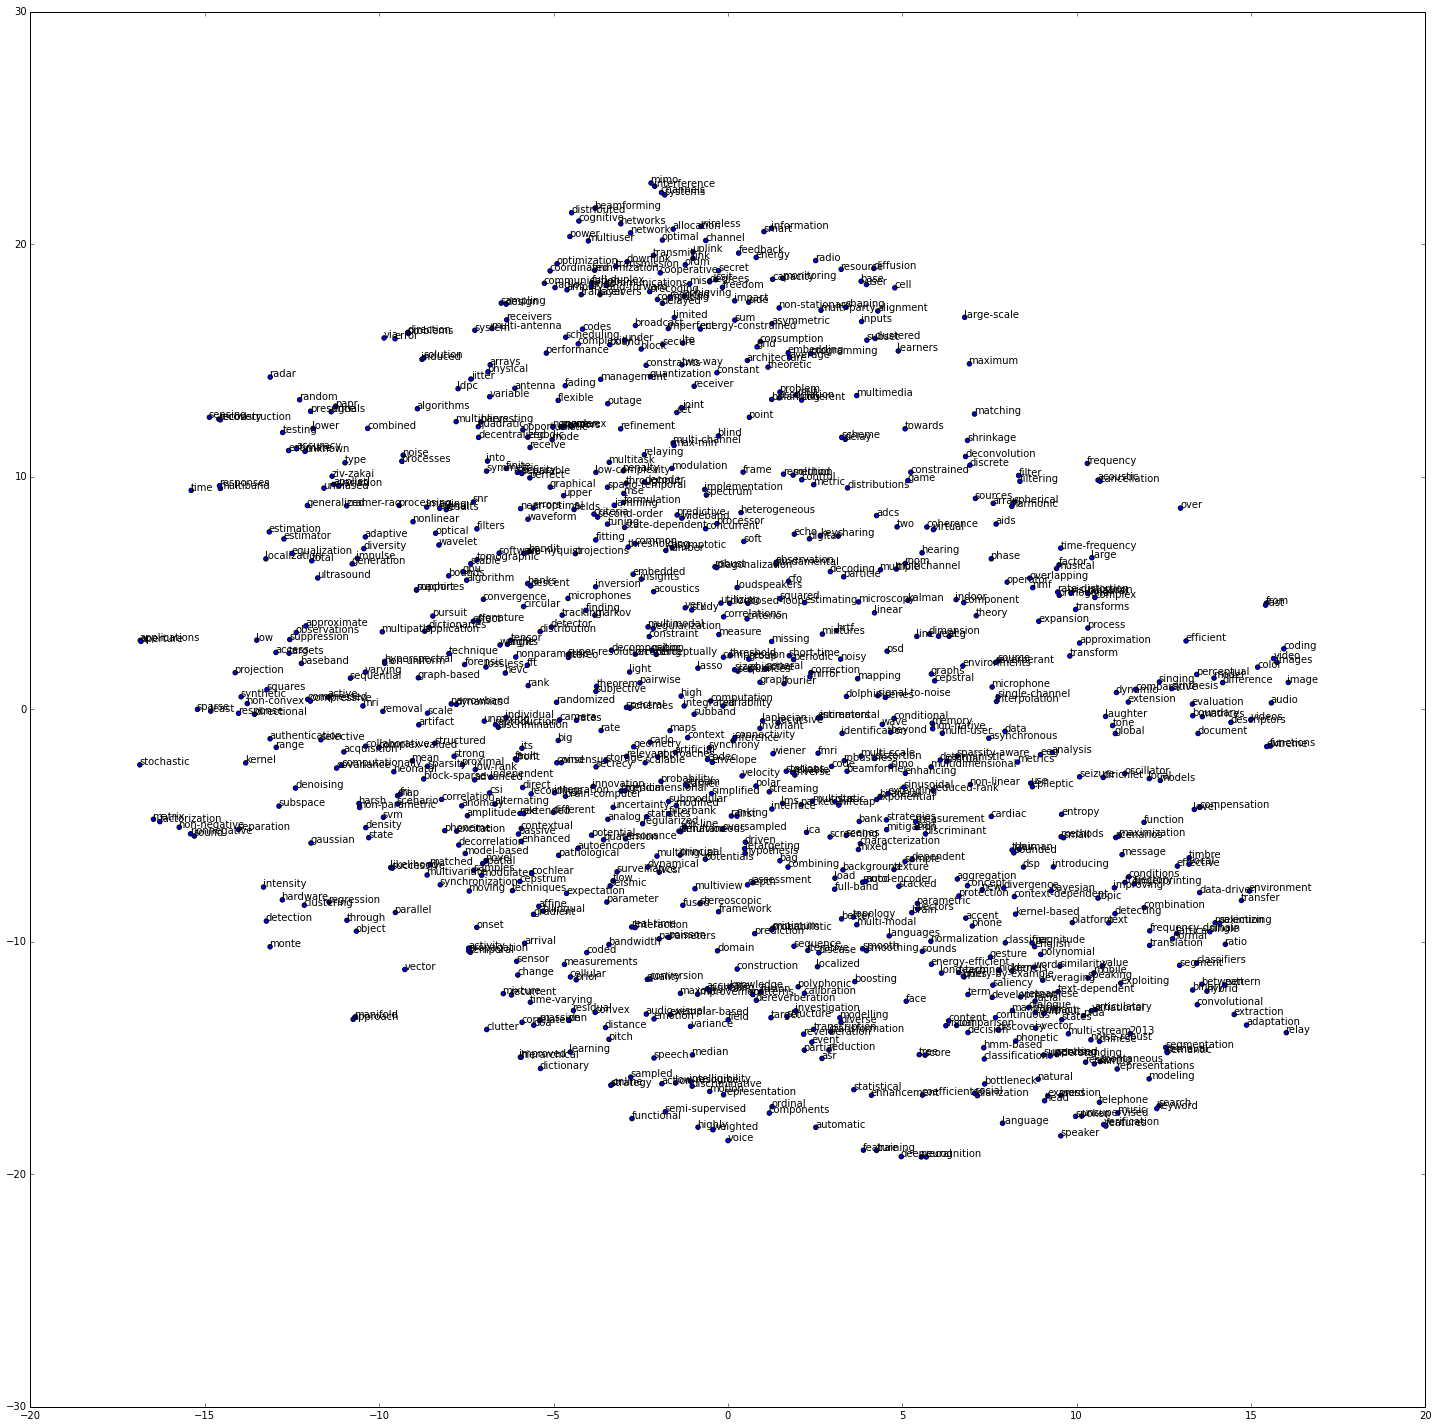

In [12]:
from tsne import bh_sne
import matplotlib.pyplot as plt

model_options = {'encoder': 'mlp', 'optimizer': sgd2, 'validFreq': 370, 'lrate': 0.0001, 
                 'batch_size': 100, 'decay_c': 0.0, 'patience': 15, 'reload_model': None, 
                 'n_qwords': 940, 'n_dwords': 940, 'max_epochs': 1000, 'dispFreq': 50, 
                 'dataset': 'icassp', 'use_dropout': False, 'dim_qproj': 20, 'dim_dproj': 10, 
                 'maxlen': 500, 'saveto': 'dssm-mlp_f-model.npz', 'noise_std': 0.0, 'saveFreq': 1110}

params = init_params(model_options)
load_params('./models/dssm-mlp_f-model.npz', params)

Q_2d = bh_sne(params['WembQ'])
labels = numpy.loadtxt("./data/icassp/contextWdict.txt", dtype='str')

fig, ax = plt.subplots()
fig.set_figheight(25)
fig.set_figwidth(25)
ax.scatter(Q_2d[:,0], Q_2d[:,1])

for i, txt in enumerate(labels):
    ax.annotate(txt, (Q_2d[i,0],Q_2d[i,1]))

### Nearest Neighbours for Words
It may difficult to have a very good visualization the words in a 2d space (especially when the vocabulary is too large or even if the word embedding training dataset is too small). An alternative approach is to look the the nearest neighbours of the words, obtained using cosine similarity of the word embeddings. This technique can also help us to (superficially) compare the embeddings learned by the two implementations presented above.

In [13]:
model_options = {'encoder': 'mlp', 'optimizer': sgd2, 'validFreq': 370, 'lrate': 0.0001, 
                 'batch_size': 100, 'decay_c': 0.0, 'patience': 15, 'reload_model': None, 
                 'n_qwords': 940, 'n_dwords': 940, 'max_epochs': 1000, 'dispFreq': 50, 
                 'dataset': 'icassp', 'use_dropout': False, 'dim_qproj': 20, 'dim_dproj': 10, 
                 'maxlen': 500, 'saveto': 'dssm-mlp_f-model.npz', 'noise_std': 0.0, 'saveFreq': 1110}

params = init_params(model_options)
load_params('./models/dssm-mlp_f-model.npz', params)
emb = params['WembQ']
embNorm = emb / numpy.sqrt((emb**2).sum(axis=1))[...,numpy.newaxis]

labels = numpy.loadtxt("./data/icassp/contextWdict.txt", dtype='str')

testWordIndices = [142, 8, 53, 19, 60, 27]
k = 5
numWrds = emb.shape[0]
print "### Nearest (word) neighbours learnt by the faster implementation of DSSM ###"
for w in testWordIndices:
    mat = numpy.tile(embNorm[w],(numWrds,1))
    sim = (mat * embNorm).sum(axis = 1)
    nbrs = numpy.argsort(sim) 
    print labels[w], " : ",
    for i in range(k):
        print labels[nbrs[numWrds - 2 - i]], " ",
    print ""
    
    
load_params('./models/dssm-mlp_model.npz', params)
emb = params['WembQ']
embNorm = emb / numpy.sqrt((emb**2).sum(axis=1))[...,numpy.newaxis]

testWordIndices = [142, 8, 53, 19, 60, 27]
k = 5
numWrds = emb.shape[0]
print "\n\n### Nearest (word) neighbours learnt by the first implementation of DSSM ###"
for w in testWordIndices:
    mat = numpy.tile(embNorm[w],(numWrds,1))
    sim = (mat * embNorm).sum(axis = 1)
    nbrs = numpy.argsort(sim) 
    print labels[w], " : ",
    for i in range(k):
        print labels[nbrs[numWrds - 2 - i]], " ",
    print ""

### Nearest (word) neighbours learnt by the faster implementation of DSSM ###
non-negative  :  nonnegative   factorization   separation   sound   effect   
neural  :  recognition   training   deep   language   adaptation   
language  :  recognition   neural   natural   diarization   social   
acoustic  :  cancellation   compensation   virtual   frequency   digital   
radar  :  selection   presence   wireless   recovery   under   
mimo  :  interference   channels   cooperative   under   optimal   


### Nearest (word) neighbours learnt by the first implementation of DSSM ###
non-negative  :  semi-supervised   nonnegative   monitoring   continuous   sharing   
neural  :  deep   i-vector   speaker   low-resource   search   
language  :  keyword   adaptation   features   social   diarization   
acoustic  :  insights   synchronization   reduction   stream   responses   
radar  :  transmission   compressed   measurements   clutter   minimization   
mimo  :  interference   power   precoding  

## Concluding Remarks
The implementation of DSSM discussed in this report helps us to understand some non-trivial aspects of the model. The most important being the choice of the negative samples for training the model. In the first attempt, with the simple choice of negative samples, the quality of word embeddings learnt and the convergence (for same number of iterations) seems poor. Incorporating a more random technique to generate the negative samples gives relatively better training convergence and embeddings. This is concluded from the comparison of the nearest neighbours learnt by both the implementations. 

The choice of negative samples also involves the choice of 'number of negative samples', which is itself a model hyper-parameter. It may appear that the DSSM model comes with more such hyper-parameters like $\gamma$ (smoothing factor for loss function) and two set of hyper-parameters for layers on query and document side. But it is easy to realise that they are equivalent to the input and output side hyper-parameters involved in training other deep neural networks. Nevertheless it would be interesting to explore these hyper-parameters and similarly the variety of hidden layer architectures (including the word hashing layer) that could be used with DSSM (for different tasks).